In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
from tabulate import tabulate


In [2]:
# ---------------------------
# Utility Functions
# ---------------------------
def process_classes(data_path, file_name):
    """
    Reads a text file containing class mappings: each line is "<index> <class_name>".
    Returns a dictionary {index: class_name}.
    """
    file_path = os.path.join(data_path, file_name + '.txt')
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

def find_invalid_filenames(df, base_dir):
    """
    Checks if image files exist in the base_dir. Returns a list of filenames that are invalid.
    """
    invalid_files = []
    for filename in df['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

def visualize_data(df_train, df_valid, column, classes_dict):
    """
    Plots a bar chart of the combined distribution of a specific column (genre/style/artist)
    across train and valid sets.
    """
    combined_counts = df_train[column].value_counts().add(df_valid[column].value_counts(), fill_value=0)
    combined_counts.sort_index().plot(kind='bar', figsize=(8, 4), legend=False)
    plt.title(f"Number of Images per {column}")
    plt.ylabel("Number of Images")
    plt.xlabel(f"{column} (class index)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [3]:
# ---------------------------
# Custom PyTorch Dataset
# ---------------------------
class ArtDataset(Dataset):
    """
    Expects a DataFrame with columns:
      - filename: image filename (relative to img_dir)
      - genre, style, artist: integer labels.
    """
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        style = int(row['style'])
        genre = int(row['genre'])
        artist = int(row['artist'])
        return image, style, genre, artist, row['filename']


In [4]:
# ---------------------------
# Convolutional-Recurrent Model (EfficientNet)
# ---------------------------
class ConvRNNClassifier(nn.Module):
    """
    Convolutional + LSTM-based model. We use an EfficientNet backbone (pretrained),
    remove the classifier layers, and feed the extracted feature map into an LSTM.
    The final LSTM hidden state is used by separate heads for style, genre, and artist classification.
    """
    def __init__(self, num_styles, num_genres, num_artists, hidden_size=256, lstm_layers=1):
        super(ConvRNNClassifier, self).__init__()
        
        # Use a pretrained EfficientNet as the backbone (EfficientNet-B0)
        efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Use the feature extractor part (all layers except the classifier)
        self.cnn = efficientnet.features
        
        # Adaptive pool to a fixed size, then LSTM expects (batch, sequence_length, features)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # EfficientNet-B0 outputs feature maps with 1280 channels
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Separate linear heads for classification tasks
        self.fc_style = nn.Linear(hidden_size, num_styles)
        self.fc_genre = nn.Linear(hidden_size, num_genres)
        self.fc_artist = nn.Linear(hidden_size, num_artists)

    def forward(self, x):
        batch_size = x.size(0)
        
        # EfficientNet CNN feature extraction
        features = self.cnn(x)  # (B, 1280, H, W)
        features = self.pool(features)  # (B, 1280, 7, 7)
        
        # Reshape: (B, 1280, 7*7) => (B, 49, 1280)
        features = features.view(batch_size, 1280, -1).permute(0, 2, 1)
        
        # LSTM processing
        lstm_out, (h_n, _) = self.lstm(features)
        final_feature = h_n[-1]  # (B, hidden_size)
        
        # Classification heads
        out_style = self.fc_style(final_feature)
        out_genre = self.fc_genre(final_feature)
        out_artist = self.fc_artist(final_feature)
        
        return out_style, out_genre, out_artist


In [5]:
# ---------------------------
# Outlier Detection
# ---------------------------
def detect_outliers(
    model, dataloader, device, 
    style_encoder, genre_encoder, artist_encoder, 
    style_classes, genre_classes, artist_classes, 
    threshold=0.3
):
    """
    Detect outliers by checking the model's confidence (softmax probability) on the "true" label.
    If confidence < threshold for style or genre or artist, we mark it as a potential outlier.
    Returns a DataFrame with potential outliers.
    """
    model.eval()
    outliers = []
    
    with torch.no_grad():
        for images, style_labels, genre_labels, artist_labels, filenames in dataloader:
            images = images.to(device)
            style_labels = style_labels.to(device)
            genre_labels = genre_labels.to(device)
            artist_labels = artist_labels.to(device)
            
            out_style, out_genre, out_artist = model(images)
            
            # Convert outputs to probabilities
            probs_style = F.softmax(out_style, dim=1)
            probs_genre = F.softmax(out_genre, dim=1)
            probs_artist = F.softmax(out_artist, dim=1)
            
            # Check each sample in the batch
            for i in range(images.size(0)):
                style_conf = probs_style[i, style_labels[i]].item()
                genre_conf = probs_genre[i, genre_labels[i]].item()
                artist_conf = probs_artist[i, artist_labels[i]].item()
                
                # If any of these is below threshold, consider it an outlier
                if (style_conf < threshold) or (genre_conf < threshold) or (artist_conf < threshold):
                    # Convert numeric label back to class names
                    style_name = style_classes[style_encoder.inverse_transform([style_labels[i].item()])[0]]
                    genre_name = genre_classes[genre_encoder.inverse_transform([genre_labels[i].item()])[0]]
                    artist_name = artist_classes[artist_encoder.inverse_transform([artist_labels[i].item()])[0]]
                    
                    outliers.append({
                        'filename': filenames[i],
                        'style': style_name,
                        'genre': genre_name,
                        'artist': artist_name,
                        'style_confidence': style_conf,
                        'genre_confidence': genre_conf,
                        'artist_confidence': artist_conf
                    })
    
    return pd.DataFrame(outliers)


In [6]:
# ---------------------------
# Main Pipeline
# ---------------------------
def main(args):
    """
    Main training + evaluation pipeline.
    1. Read class definitions and CSV files.
    2. Clean data (remove invalid filenames).
    3. Encode labels consistently.
    4. Build and train ConvRNN model.
    5. Evaluate and plot results.
    6. Detect and visualize outliers.
    """
    
    # Paths in your Kaggle environment
    datapath = '/kaggle/input/wikiart'       # All images located here
    genres_datapath = '/kaggle/input/genres-ds'
    styles_datapath = '/kaggle/input/style-ds'
    artist_datapath = '/kaggle/input/gsocdata'
    
    # 1. Read class mappings
    genres_classes = process_classes(genres_datapath, 'genre_class')
    styles_classes = process_classes(styles_datapath, 'style_class')
    artist_classes = process_classes(artist_datapath, 'artist_class')
    print("Class Mappings:")
    print(f"Genres:  {len(genres_classes)} classes")
    print(f"Styles:  {len(styles_classes)} classes")
    print(f"Artists: {len(artist_classes)} classes\n")

    # 2. Read CSVs for train/val splits
    genre_data_train = pd.read_csv(os.path.join(genres_datapath, 'genre_train.csv'))
    genre_data_valid = pd.read_csv(os.path.join(genres_datapath, 'genre_val.csv'))

    style_data_train = pd.read_csv(
        os.path.join(styles_datapath, 'style_train.csv'), header=None, names=['filename', 'style']
    )
    style_data_valid = pd.read_csv(
        os.path.join(styles_datapath, 'style_val.csv'),   header=None, names=['filename', 'style']
    )

    artist_data_train = pd.read_csv(
        os.path.join(artist_datapath, 'artist_train.csv'), header=None, names=['filename', 'artist']
    )
    artist_data_valid = pd.read_csv(
        os.path.join(artist_datapath, 'artist_val.csv'),   header=None, names=['filename', 'artist']
    )

    # Merge datasets on "filename"
    data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
    data_train = pd.merge(data_train, artist_data_train, on='filename')
    
    data_valid = pd.merge(genre_data_valid, style_data_valid, on='filename', suffixes=('_genre', '_style'))
    data_valid = pd.merge(data_valid, artist_data_valid, on='filename')

    print("Sample of Merged Train Data:")
    print(data_train.head(), "\n")

    # Quick check for missing values
    print("Missing values in train:\n", data_train.isnull().sum(), "\n")
    print("Missing values in valid:\n", data_valid.isnull().sum(), "\n")

    # Check and remove invalid files
    invalid_train = find_invalid_filenames(data_train, datapath)
    invalid_valid = find_invalid_filenames(data_valid, datapath)
    print(f"Invalid train files: {len(invalid_train)}")
    print(f"Invalid valid files: {len(invalid_valid)}")

    data_train_cleaned = data_train[~data_train['filename'].isin(invalid_train)]
    data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_valid)]
    print(f"Train set size after cleaning: {len(data_train_cleaned)}")
    print(f"Valid set size after cleaning: {len(data_valid_cleaned)}\n")

    # Visualize distributions
    visualize_data(data_train_cleaned, data_valid_cleaned, 'genre', genres_classes)
    visualize_data(data_train_cleaned, data_valid_cleaned, 'style', styles_classes)
    visualize_data(data_train_cleaned, data_valid_cleaned, 'artist', artist_classes)

    # ---------------------------
    # 3. Label Encoding
    # ---------------------------
    combined_data = pd.concat([data_train_cleaned, data_valid_cleaned])

    style_encoder = LabelEncoder()
    genre_encoder = LabelEncoder()
    artist_encoder = LabelEncoder()

    style_encoder.fit(combined_data['style'])
    genre_encoder.fit(combined_data['genre'])
    artist_encoder.fit(combined_data['artist'])

    # Apply transform
    data_train_cleaned.loc[:, 'style'] = style_encoder.transform(data_train_cleaned['style'])
    data_train_cleaned.loc[:, 'genre'] = genre_encoder.transform(data_train_cleaned['genre'])
    data_train_cleaned.loc[:, 'artist'] = artist_encoder.transform(data_train_cleaned['artist'])

    data_valid_cleaned.loc[:, 'style'] = style_encoder.transform(data_valid_cleaned['style'])
    data_valid_cleaned.loc[:, 'genre'] = genre_encoder.transform(data_valid_cleaned['genre'])
    data_valid_cleaned.loc[:, 'artist'] = artist_encoder.transform(data_valid_cleaned['artist'])

    num_styles = len(style_encoder.classes_)
    num_genres = len(genre_encoder.classes_)
    num_artists = len(artist_encoder.classes_)

    print("Encoded Label Ranges:")
    print(f" Style labels: 0 to {num_styles-1}")
    print(f" Genre labels: 0 to {num_genres-1}")
    print(f" Artist labels: 0 to {num_artists-1}\n")

    # ---------------------------
    # Train / Valid / Test Split
    # ---------------------------
    train_data_split, temp_data = train_test_split(
        data_train_cleaned,
        test_size=0.30,
        random_state=42,
        stratify=data_train_cleaned['genre']
    )
    valid_data_split, test_data = train_test_split(
        temp_data,
        test_size=0.5,
        random_state=42
    )

    print("Data splits after custom split:")
    print(f" Train: {train_data_split.shape[0]} samples")
    print(f" Validation: {valid_data_split.shape[0]} samples")
    print(f" Test: {test_data.shape[0]} samples\n")

    # ---------------------------
    # Weighted Sampler for Imbalance
    # ---------------------------
    genre_counts = train_data_split['genre'].value_counts().to_dict()
    weights = train_data_split['genre'].apply(lambda x: 1.0 / genre_counts[x]).values
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    # Free up GPU memory if needed
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device, "\n")

    # ---------------------------
    # 4. Image Transforms
    # ---------------------------
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((args.img_size, args.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # ---------------------------
    # 5. Datasets and Loaders
    # ---------------------------
    train_dataset = ArtDataset(train_data_split, datapath, transform=train_transform)
    valid_dataset = ArtDataset(valid_data_split, datapath, transform=val_transform)
    test_dataset  = ArtDataset(test_data,        datapath, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, num_workers=4)
    train_eval_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=args.batch_size, shuffle=False, num_workers=4)

    # ---------------------------
    # 6. Initialize Model, Optimizer, Loss
    # ---------------------------
    model = ConvRNNClassifier(
        num_styles=num_styles,
        num_genres=num_genres,
        num_artists=num_artists,
        hidden_size=256,
        lstm_layers=1
    )
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    # ---------------------------
    # 7. Training Loop
    # ---------------------------
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_style_acc': [],
        'train_genre_acc': [],
        'train_artist_acc': [],
        'val_style_acc': [],
        'val_genre_acc': [],
        'val_artist_acc': []
    }

    for epoch in range(args.epochs):
        model.train()
        running_loss = 0.0
        
        # Mini-batch training
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epochs}")
        for i, (images, style_labels, genre_labels, artist_labels, _) in pbar:
            images = images.to(device)
            style_labels = style_labels.to(device)
            genre_labels = genre_labels.to(device)
            artist_labels = artist_labels.to(device)

            optimizer.zero_grad()

            out_style, out_genre, out_artist = model(images)
            loss_style  = criterion(out_style,  style_labels)
            loss_genre  = criterion(out_genre,  genre_labels)
            loss_artist = criterion(out_artist, artist_labels)
            loss = loss_style + loss_genre + loss_artist
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        
        print(f"\n[Epoch {epoch+1}/{args.epochs}] Training Average Loss: {avg_loss:.4f}")

        # Evaluate on the entire training set for metrics (optional but helps track overfitting)
        model.eval()
        all_train_style_preds, all_train_genre_preds, all_train_artist_preds = [], [], []
        all_train_style_labels, all_train_genre_labels, all_train_artist_labels = [], [], []

        with torch.no_grad():
            for images, style_labels, genre_labels, artist_labels, _ in train_eval_loader:
                images = images.to(device)
                style_labels = style_labels.to(device)
                genre_labels = genre_labels.to(device)
                artist_labels = artist_labels.to(device)
                
                out_style, out_genre, out_artist = model(images)
                
                pred_style  = torch.argmax(F.softmax(out_style,  dim=1), dim=1)
                pred_genre  = torch.argmax(F.softmax(out_genre,  dim=1), dim=1)
                pred_artist = torch.argmax(F.softmax(out_artist, dim=1), dim=1)
                
                all_train_style_preds.extend(pred_style.cpu().numpy())
                all_train_genre_preds.extend(pred_genre.cpu().numpy())
                all_train_artist_preds.extend(pred_artist.cpu().numpy())
                
                all_train_style_labels.extend(style_labels.cpu().numpy())
                all_train_genre_labels.extend(genre_labels.cpu().numpy())
                all_train_artist_labels.extend(artist_labels.cpu().numpy())

        train_acc_style  = accuracy_score(all_train_style_labels,  all_train_style_preds)
        train_acc_genre  = accuracy_score(all_train_genre_labels,  all_train_genre_preds)
        train_acc_artist = accuracy_score(all_train_artist_labels, all_train_artist_preds)
        
        history['train_style_acc'].append(train_acc_style)
        history['train_genre_acc'].append(train_acc_genre)
        history['train_artist_acc'].append(train_acc_artist)
        
        print("Training Metrics:")
        print(f"  Style  - Accuracy: {train_acc_style:.4f}")
        print(f"  Genre  - Accuracy: {train_acc_genre:.4f}")
        print(f"  Artist - Accuracy: {train_acc_artist:.4f}\n")

        # Validation Phase
        val_loss = 0.0
        all_style_preds, all_genre_preds, all_artist_preds = [], [], []
        all_style_labels, all_genre_labels, all_artist_labels = [], [], []

        with torch.no_grad():
            for images, style_labels, genre_labels, artist_labels, _ in valid_loader:
                images = images.to(device)
                style_labels = style_labels.to(device)
                genre_labels = genre_labels.to(device)
                artist_labels = artist_labels.to(device)
                
                out_style, out_genre, out_artist = model(images)
                
                loss_style  = criterion(out_style,  style_labels)
                loss_genre  = criterion(out_genre,  genre_labels)
                loss_artist = criterion(out_artist, artist_labels)
                
                val_loss += (loss_style + loss_genre + loss_artist).item()
                
                pred_style  = torch.argmax(F.softmax(out_style,  dim=1), dim=1)
                pred_genre  = torch.argmax(F.softmax(out_genre,  dim=1), dim=1)
                pred_artist = torch.argmax(F.softmax(out_artist, dim=1), dim=1)
                
                all_style_preds.extend(pred_style.cpu().numpy())
                all_genre_preds.extend(pred_genre.cpu().numpy())
                all_artist_preds.extend(pred_artist.cpu().numpy())
                
                all_style_labels.extend(style_labels.cpu().numpy())
                all_genre_labels.extend(genre_labels.cpu().numpy())
                all_artist_labels.extend(artist_labels.cpu().numpy())

        avg_val_loss = val_loss / len(valid_loader)
        history['val_loss'].append(avg_val_loss)

        acc_style  = accuracy_score(all_style_labels,  all_style_preds)
        acc_genre  = accuracy_score(all_genre_labels,  all_genre_preds)
        acc_artist = accuracy_score(all_artist_labels, all_artist_preds)

        history['val_style_acc'].append(acc_style)
        history['val_genre_acc'].append(acc_genre)
        history['val_artist_acc'].append(acc_artist)

        print(f"Validation Loss: {avg_val_loss:.4f}")
        print("Validation Metrics:")
        print(f"  Style  - Accuracy: {acc_style:.4f}")
        print(f"  Genre  - Accuracy: {acc_genre:.4f}")
        print(f"  Artist - Accuracy: {acc_artist:.4f}\n")

        # Save checkpoint
        checkpoint_path = f"conv_rnn_classifier_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
            'val_acc_style': acc_style,
            'val_acc_genre': acc_genre,
            'val_acc_artist': acc_artist,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}\n{'-'*50}")

    # ---------------------------
    # 8. Save Final Model
    # ---------------------------
    torch.save(model.state_dict(), "conv_rnn_classifier_final.pth")
    print("\nTraining complete. Final model saved as conv_rnn_classifier_final.pth\n")

    # ---------------------------
    # 9. Plot Training History
    # ---------------------------
    plt.figure(figsize=(12, 4))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    
    # Accuracy curves (just for style, genre, artist on validation)
    plt.subplot(1, 2, 2)
    plt.plot(history['val_style_acc'],  label='Style Acc')
    plt.plot(history['val_genre_acc'],  label='Genre Acc')
    plt.plot(history['val_artist_acc'], label='Artist Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    # ---------------------------
    # 10. Final Evaluation on Test Set
    # ---------------------------
    model.eval()
    all_test_style_preds, all_test_genre_preds, all_test_artist_preds = [], [], []
    all_test_style_labels, all_test_genre_labels, all_test_artist_labels = [], [], []

    with torch.no_grad():
        for images, style_labels, genre_labels, artist_labels, _ in test_loader:
            images = images.to(device)
            style_labels = style_labels.to(device)
            genre_labels = genre_labels.to(device)
            artist_labels = artist_labels.to(device)
            
            out_style, out_genre, out_artist = model(images)
            
            pred_style  = torch.argmax(F.softmax(out_style,  dim=1), dim=1)
            pred_genre  = torch.argmax(F.softmax(out_genre,  dim=1), dim=1)
            pred_artist = torch.argmax(F.softmax(out_artist, dim=1), dim=1)
            
            all_test_style_preds.extend(pred_style.cpu().numpy())
            all_test_genre_preds.extend(pred_genre.cpu().numpy())
            all_test_artist_preds.extend(pred_artist.cpu().numpy())
            
            all_test_style_labels.extend(style_labels.cpu().numpy())
            all_test_genre_labels.extend(genre_labels.cpu().numpy())
            all_test_artist_labels.extend(artist_labels.cpu().numpy())

    test_acc_style  = accuracy_score(all_test_style_labels,  all_test_style_preds)
    test_acc_genre  = accuracy_score(all_test_genre_labels,  all_test_genre_preds)
    test_acc_artist = accuracy_score(all_test_artist_labels, all_test_artist_preds)

    print("\nFinal Test Set Performance:")
    print(f" Style  - Accuracy: {test_acc_style:.4f}")
    print(f" Genre  - Accuracy: {test_acc_genre:.4f}")
    print(f" Artist - Accuracy: {test_acc_artist:.4f}")

    # Plot a confusion matrix for style on test set, focusing on the top 10 classes
    style_class_names = [styles_classes[style_encoder.inverse_transform([i])[0]] for i in range(num_styles)]
    
    # We pick top 10 style classes by their frequency in the test set
    style_counts_test = pd.Series(all_test_style_labels).value_counts().sort_values(ascending=False)
    top_10_styles = style_counts_test.head(10).index
    mask_top_10 = np.isin(all_test_style_labels, top_10_styles)

    plot_confusion_matrix(
        np.array(all_test_style_labels)[mask_top_10],
        np.array(all_test_style_preds)[mask_top_10],
        [style_class_names[i] for i in top_10_styles],
        title='Style Confusion Matrix (Top 10 on Test Set)'
    )

    # ---------------------------
    # 11. Outlier Detection
    # ---------------------------
    print("\n--- Outlier Detection on Test Set ---")
    outliers_df = detect_outliers(
        model, test_loader, device,
        style_encoder, genre_encoder, artist_encoder,
        styles_classes, genres_classes, artist_classes,
        threshold=0.3
    )

    if len(outliers_df) == 0:
        print("No outliers detected with the current threshold.")
        return

    # Sort outliers by minimum confidence
    outliers_df['min_confidence'] = outliers_df[['style_confidence','genre_confidence','artist_confidence']].min(axis=1)
    outliers_df = outliers_df.sort_values('min_confidence')

    print(f"Found {len(outliers_df)} potential outliers.")
    print("Top 10 outliers (lowest confidence):\n")
    print(tabulate(outliers_df.head(10), headers='keys', tablefmt='psql'))

    # Save full outliers as CSV
    outliers_df.to_csv('art_outliers.csv', index=False)
    print("\nFull outlier list saved to 'art_outliers.csv'")

    # ---------------------------
    # 12. Visualize Some Outliers
    # ---------------------------
    # Display the first 6 outliers in a 2-row x 3-column grid
    outliers_to_show = outliers_df.head(6)
    plt.figure(figsize=(12, 8))
    for idx, (_, row) in enumerate(outliers_to_show.iterrows()):
        plt.subplot(2, 3, idx+1)
        img_path = os.path.join(datapath, row['filename'])
        img = Image.open(img_path).convert('RGB')
        plt.imshow(img)
        plt.title(
            f"Artist: {row['artist']}\n"
            f"Genre: {row['genre']}\n"
            f"Style: {row['style']}\n"
            f"Conf: {row['min_confidence']:.2f}"
        )
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('outlier_samples.png')
    plt.show()


Running on device: cuda
Class Mappings:
Genres:  10 classes
Styles:  27 classes
Artists: 23 classes

Sample of Merged Train Data:
                                            filename  genre  style  artist
0  Post_Impressionism/vincent-van-gogh_ears-of-wh...      4     20      22
1  Expressionism/martiros-saryan_mother-of-the-ar...      6      9      13
2  Naive_Art_Primitivism/marc-chagall_clown-with-...      2     15      12
3  Northern_Renaissance/albrecht-durer_temptation...      7     17       0
4  Impressionism/pierre-auguste-renoir_woman-with...      6     12      17 

Missing values in train:
 filename    0
genre       0
style       0
artist      0
dtype: int64 

Missing values in valid:
 filename    0
genre       0
style       0
artist      0
dtype: int64 

Invalid train files: 2
Invalid valid files: 0
Train set size after cleaning: 11274
Valid set size after cleaning: 4707



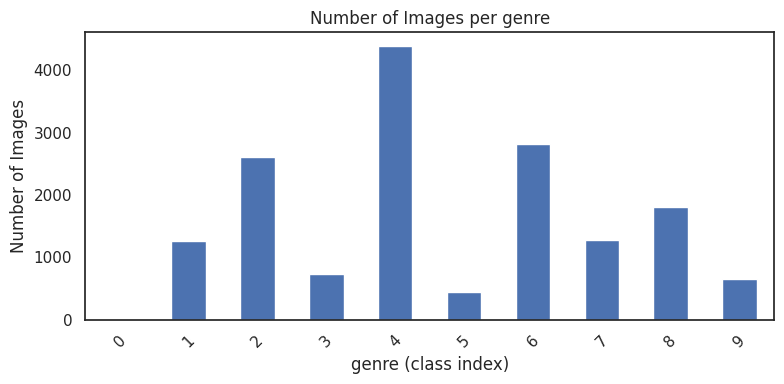

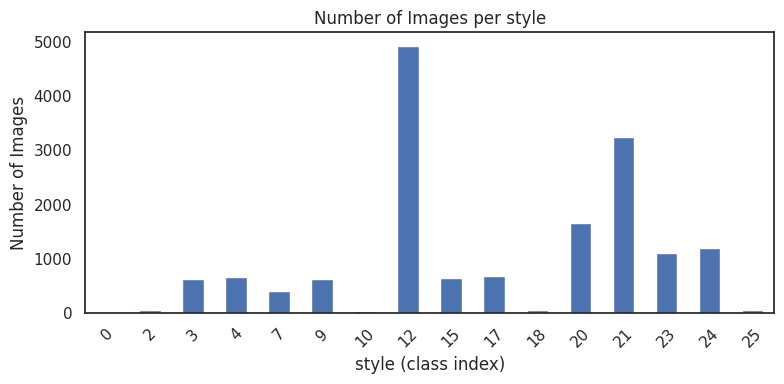

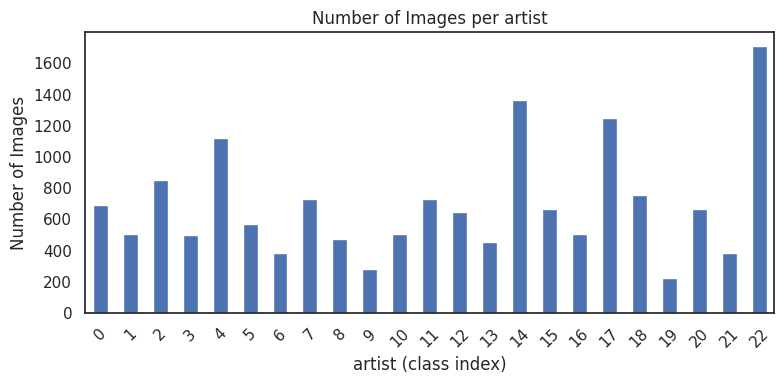

Encoded Label Ranges:
 Style labels: 0 to 15
 Genre labels: 0 to 9
 Artist labels: 0 to 22

Data splits after custom split:
 Train: 7891 samples
 Validation: 1691 samples
 Test: 1692 samples

Using device: cuda:0 



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s]
Epoch 1/12: 100%|██████████| 494/494 [02:04<00:00,  3.96it/s, loss=7.5509]


[Epoch 1/12] Training Average Loss: 5.8277


Training Metrics:
  Style  - Accuracy: 0.4405
  Genre  - Accuracy: 0.2369
  Artist - Accuracy: 0.2592

Validation Loss: 5.9792
Validation Metrics:
  Style  - Accuracy: 0.4678
  Genre  - Accuracy: 0.2501
  Artist - Accuracy: 0.2726

Checkpoint saved: conv_rnn_classifier_epoch_1.pth
--------------------------------------------------


Epoch 2/12: 100%|██████████| 494/494 [01:56<00:00,  4.25it/s, loss=4.7619]


[Epoch 2/12] Training Average Loss: 5.3932


Training Metrics:
  Style  - Accuracy: 0.4609
  Genre  - Accuracy: 0.3138
  Artist - Accuracy: 0.2826

Validation Loss: 5.8118
Validation Metrics:
  Style  - Accuracy: 0.4524
  Genre  - Accuracy: 0.3087
  Artist - Accuracy: 0.2797

Checkpoint saved: conv_rnn_classifier_epoch_2.pth
--------------------------------------------------


Epoch 3/12: 100%|██████████| 494/494 [01:57<00:00,  4.20it/s, loss=6.6024]


[Epoch 3/12] Training Average Loss: 5.2921


Training Metrics:
  Style  - Accuracy: 0.4438
  Genre  - Accuracy: 0.3060
  Artist - Accuracy: 0.2816

Validation Loss: 5.9219
Validation Metrics:
  Style  - Accuracy: 0.4382
  Genre  - Accuracy: 0.2933
  Artist - Accuracy: 0.2655

Checkpoint saved: conv_rnn_classifier_epoch_3.pth
--------------------------------------------------


Epoch 4/12: 100%|██████████| 494/494 [01:56<00:00,  4.23it/s, loss=4.1488]


[Epoch 4/12] Training Average Loss: 5.1595


Training Metrics:
  Style  - Accuracy: 0.4728
  Genre  - Accuracy: 0.3925
  Artist - Accuracy: 0.3096

Validation Loss: 5.6583
Validation Metrics:
  Style  - Accuracy: 0.4642
  Genre  - Accuracy: 0.3921
  Artist - Accuracy: 0.3111

Checkpoint saved: conv_rnn_classifier_epoch_4.pth
--------------------------------------------------


Epoch 5/12: 100%|██████████| 494/494 [01:57<00:00,  4.21it/s, loss=6.9473]


[Epoch 5/12] Training Average Loss: 5.0906


Training Metrics:
  Style  - Accuracy: 0.4742
  Genre  - Accuracy: 0.3134
  Artist - Accuracy: 0.2837

Validation Loss: 5.7216
Validation Metrics:
  Style  - Accuracy: 0.4755
  Genre  - Accuracy: 0.3146
  Artist - Accuracy: 0.2774

Checkpoint saved: conv_rnn_classifier_epoch_5.pth
--------------------------------------------------


Epoch 6/12: 100%|██████████| 494/494 [01:57<00:00,  4.22it/s, loss=7.0563]


[Epoch 6/12] Training Average Loss: 4.9934


Training Metrics:
  Style  - Accuracy: 0.4882
  Genre  - Accuracy: 0.3961
  Artist - Accuracy: 0.3267

Validation Loss: 5.3975
Validation Metrics:
  Style  - Accuracy: 0.5003
  Genre  - Accuracy: 0.4080
  Artist - Accuracy: 0.3235

Checkpoint saved: conv_rnn_classifier_epoch_6.pth
--------------------------------------------------


Epoch 7/12: 100%|██████████| 494/494 [01:56<00:00,  4.23it/s, loss=6.2665]


[Epoch 7/12] Training Average Loss: 4.9325


Training Metrics:
  Style  - Accuracy: 0.4698
  Genre  - Accuracy: 0.3275
  Artist - Accuracy: 0.3117

Validation Loss: 5.5451
Validation Metrics:
  Style  - Accuracy: 0.4802
  Genre  - Accuracy: 0.3341
  Artist - Accuracy: 0.3199

Checkpoint saved: conv_rnn_classifier_epoch_7.pth
--------------------------------------------------


Epoch 8/12: 100%|██████████| 494/494 [01:57<00:00,  4.22it/s, loss=6.4787]


[Epoch 8/12] Training Average Loss: 4.8157


Training Metrics:
  Style  - Accuracy: 0.4960
  Genre  - Accuracy: 0.4248
  Artist - Accuracy: 0.3409

Validation Loss: 5.3239
Validation Metrics:
  Style  - Accuracy: 0.4867
  Genre  - Accuracy: 0.4211
  Artist - Accuracy: 0.3294

Checkpoint saved: conv_rnn_classifier_epoch_8.pth
--------------------------------------------------


Epoch 9/12: 100%|██████████| 494/494 [01:55<00:00,  4.29it/s, loss=6.4221]


[Epoch 9/12] Training Average Loss: 4.9635


Training Metrics:
  Style  - Accuracy: 0.4899
  Genre  - Accuracy: 0.3813
  Artist - Accuracy: 0.3202

Validation Loss: 5.4605
Validation Metrics:
  Style  - Accuracy: 0.4820
  Genre  - Accuracy: 0.3779
  Artist - Accuracy: 0.3182

Checkpoint saved: conv_rnn_classifier_epoch_9.pth
--------------------------------------------------


Epoch 10/12: 100%|██████████| 494/494 [01:57<00:00,  4.21it/s, loss=6.5092]


[Epoch 10/12] Training Average Loss: 4.8096


Training Metrics:
  Style  - Accuracy: 0.4884
  Genre  - Accuracy: 0.3490
  Artist - Accuracy: 0.3240

Validation Loss: 5.4903
Validation Metrics:
  Style  - Accuracy: 0.5021
  Genre  - Accuracy: 0.3288
  Artist - Accuracy: 0.3306

Checkpoint saved: conv_rnn_classifier_epoch_10.pth
--------------------------------------------------


Epoch 11/12: 100%|██████████| 494/494 [01:58<00:00,  4.18it/s, loss=5.3029]


[Epoch 11/12] Training Average Loss: 4.8958


Training Metrics:
  Style  - Accuracy: 0.4658
  Genre  - Accuracy: 0.3295
  Artist - Accuracy: 0.3112

Validation Loss: 5.6446
Validation Metrics:
  Style  - Accuracy: 0.4879
  Genre  - Accuracy: 0.3465
  Artist - Accuracy: 0.3152

Checkpoint saved: conv_rnn_classifier_epoch_11.pth
--------------------------------------------------


Epoch 12/12: 100%|██████████| 494/494 [01:54<00:00,  4.31it/s, loss=4.7122]


[Epoch 12/12] Training Average Loss: 4.8553


Training Metrics:
  Style  - Accuracy: 0.4973
  Genre  - Accuracy: 0.3901
  Artist - Accuracy: 0.3442

Validation Loss: 5.3187
Validation Metrics:
  Style  - Accuracy: 0.5127
  Genre  - Accuracy: 0.3661
  Artist - Accuracy: 0.3430

Checkpoint saved: conv_rnn_classifier_epoch_12.pth
--------------------------------------------------

Training complete. Final model saved as conv_rnn_classifier_final.pth



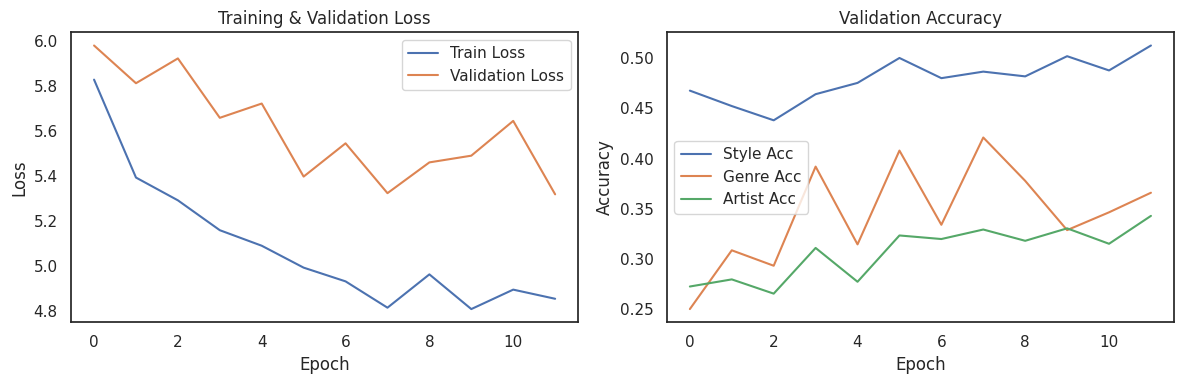


Final Test Set Performance:
 Style  - Accuracy: 0.4734
 Genre  - Accuracy: 0.3576
 Artist - Accuracy: 0.3257


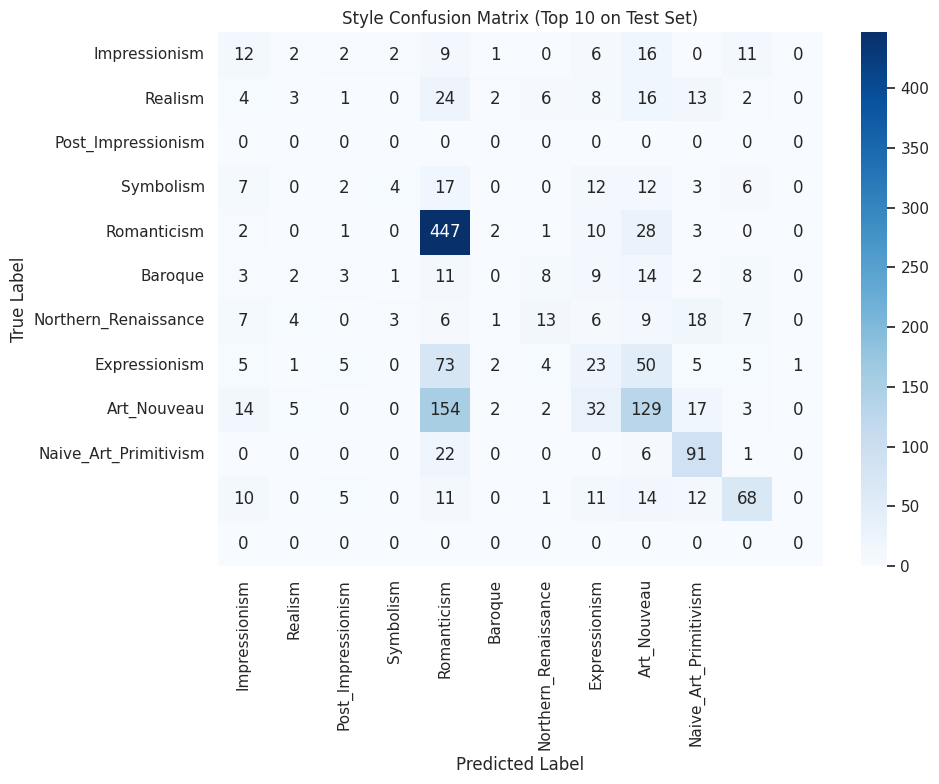


--- Outlier Detection on Test Set ---
Found 1485 potential outliers.
Top 10 outliers (lowest confidence):

+------+--------------------------------------------------------------------------+-----------------------+--------------------+------------------+--------------------+--------------------+---------------------+------------------+
|      | filename                                                                 | style                 | genre              | artist           |   style_confidence |   genre_confidence |   artist_confidence |   min_confidence |
|------+--------------------------------------------------------------------------+-----------------------+--------------------+------------------+--------------------+--------------------+---------------------+------------------|
| 1385 | Art_Nouveau_Modern/raphael-kirchner_justine-johnstone-2.jpg              | Art_Nouveau           | portrait           | Raphael_Kirchner |        0.00175176  |          0.274589  |         0

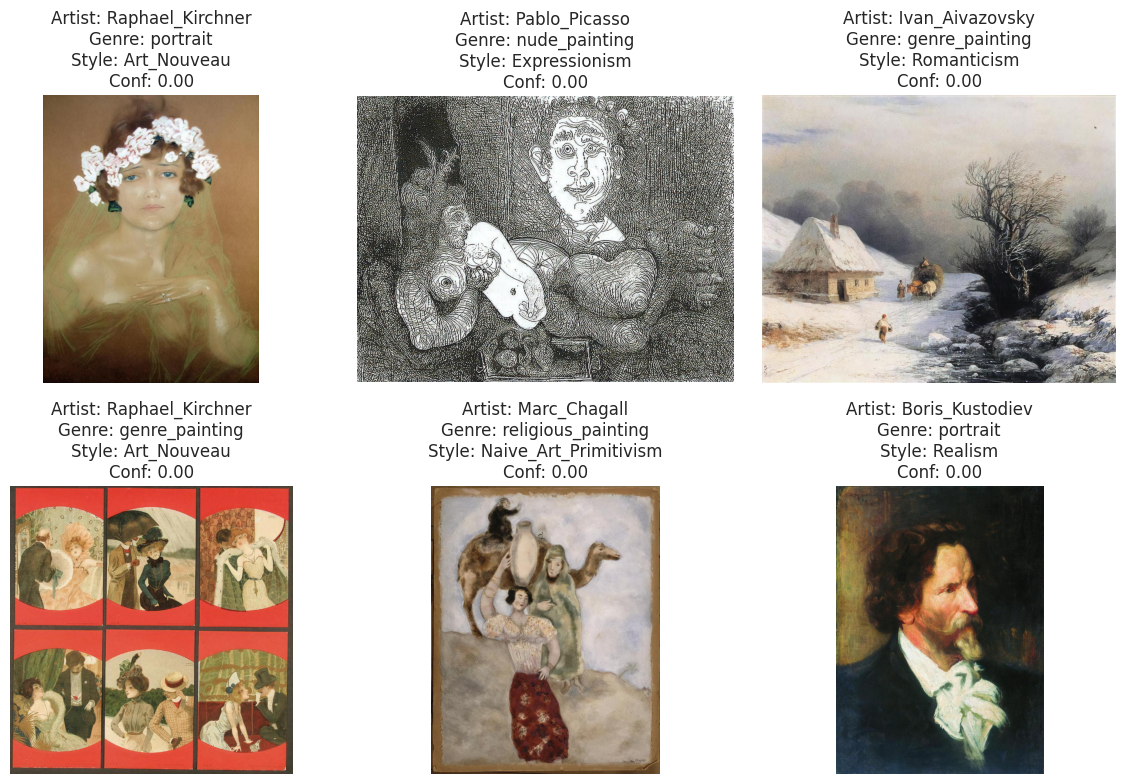

In [7]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="Train Convolutional-Recurrent Art Classifier")
    parser.add_argument('--batch_size', type=int, default=16, help='Batch size for training')
    parser.add_argument('--epochs', type=int, default=12, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=2e-3, help='Learning rate')
    parser.add_argument('--img_size', type=int, default=224, help='Input image size')
    
    args, _ = parser.parse_known_args()
    print(f"Running on device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    main(args)
